In [182]:
import pandas as pd
from forex_python.converter import CurrencyRates
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

In [146]:
df = pd.read_csv('task2.csv')

df = df.drop_duplicates()

df = df.dropna()

df

,Work_Year,Experience_Level,Employment_Type,Job_Title,Salary,Salary_Currency,Remote_Ratio,Company_Size
0,2024,Senior-Level,Full-Time,AI Engineer,90000,USD,0,Large
1,2024,Senior-Level,Full-Time,Machine Learning Engineer,180500,USD,0,Medium
2,2024,Senior-Level,Full-Time,Machine Learning Engineer,96200,USD,0,Medium
3,2024,Senior-Level,Full-Time,Machine Learning Engineer,235000,USD,0,Medium
4,2024,Senior-Level,Full-Time,Machine Learning Engineer,175000,USD,0,Medium
...,...,...,...,...,...,...,...,...
13967,2020,Senior-Level,Full-Time,Data Scientist,412000,USD,100,Large
13968,2021,Mid-Level,Full-Time,Principal Data Scientist,151000,USD,100,Large
13969,2020,Entry-Level,Full-Time,Data Scientist,105000,USD,100,S
13970,2020,Entry-Level,Contract,Business Data Analyst,100000,USD,100,Large


In [147]:
currency_counts = df['Salary_Currency'].value_counts()
print("before:")
currency_counts

before:


Salary_Currency
USD    7499
GBP     410
EUR     339
INR      52
CAD      48
AUD      12
PLN       7
CHF       6
SGD       6
JPY       4
BRL       4
DKK       3
HUF       3
TRY       3
NOK       2
THB       2
ZAR       1
HKD       1
ILS       1
PHP       1
NZD       1
MXN       1
CLP       1
Name: count, dtype: int64

In [148]:
valid_currencies = currency_counts[currency_counts >= 10].index
df_filtered = df[df['Salary_Currency'].isin(valid_currencies)]

print("after:")
df_filtered['Salary_Currency'].value_counts()

after:


Salary_Currency
USD    7499
GBP     410
EUR     339
INR      52
CAD      48
AUD      12
Name: count, dtype: int64

In [149]:
df_filtered

,Work_Year,Experience_Level,Employment_Type,Job_Title,Salary,Salary_Currency,Remote_Ratio,Company_Size
0,2024,Senior-Level,Full-Time,AI Engineer,90000,USD,0,Large
1,2024,Senior-Level,Full-Time,Machine Learning Engineer,180500,USD,0,Medium
2,2024,Senior-Level,Full-Time,Machine Learning Engineer,96200,USD,0,Medium
3,2024,Senior-Level,Full-Time,Machine Learning Engineer,235000,USD,0,Medium
4,2024,Senior-Level,Full-Time,Machine Learning Engineer,175000,USD,0,Medium
...,...,...,...,...,...,...,...,...
13967,2020,Senior-Level,Full-Time,Data Scientist,412000,USD,100,Large
13968,2021,Mid-Level,Full-Time,Principal Data Scientist,151000,USD,100,Large
13969,2020,Entry-Level,Full-Time,Data Scientist,105000,USD,100,S
13970,2020,Entry-Level,Contract,Business Data Analyst,100000,USD,100,Large


In [155]:
currencies = df_filtered['Salary_Currency'].unique()
conversion_rates = {i:{} for i in currencies}

c = CurrencyRates()

for currency in currencies:
    try:
        for year in range(2020,2025):
            conversion_rates[currency][year] = c.get_rate(currency, 'USD', datetime(year, 1, 1))
    except Exception as e:
        print(f"Error fetching conversion rate for {currency}: {e}")

conversion_rates

{'USD': {2020: 1.0, 2021: 1.0, 2022: 1.0, 2023: 1.0, 2024: 1.0},
 'EUR': {2020: 1.1234, 2021: 1.2271, 2022: 1.1326, 2023: 1.0666, 2024: 1.105},
 'GBP': {2020: 1.3204043253408555,
  2021: 1.3649155200605096,
  2022: 1.347884038653782,
  2023: 1.2025751750419988,
  2024: 1.2715033657442034},
 'CAD': {2020: 0.7695574736265242,
  2021: 0.7849421096398644,
  2022: 0.7869103036198152,
  2023: 0.7386426592797785,
  2024: 0.75467832263352},
 'AUD': {2020: 0.7023444826508284,
  2021: 0.7719552088575743,
  2022: 0.7253282100544348,
  2023: 0.6796660931625566,
  2024: 0.6794564348521183},
 'INR': {2020: 0.014009752204222629,
  2021: 0.013686071346914195,
  2022: 0.013446643206868876,
  2023: 0.01209694797609191,
  2024: 0.012023350325609736}}

In [157]:
def convert_to_usd(row):
    amount = row['Salary']
    currency = row['Salary_Currency']
    Work_Year=row['Work_Year']
    try:
        return amount * conversion_rates[currency][Work_Year]
    except KeyError:
        print(f"Conversion rate for {currency} not found.")
        return None

df_filtered['Salary_in_USD'] = df_filtered.apply(convert_to_usd, axis=1)

df_filtered = df_filtered.dropna(subset=['Salary_in_USD'])

df_filtered

,Work_Year,Experience_Level,Employment_Type,Job_Title,Salary,Salary_Currency,Remote_Ratio,Company_Size,Salary_in_USD
0,2024,Senior-Level,Full-Time,AI Engineer,90000,USD,0,Large,90000.000000
1,2024,Senior-Level,Full-Time,Machine Learning Engineer,180500,USD,0,Medium,180500.000000
2,2024,Senior-Level,Full-Time,Machine Learning Engineer,96200,USD,0,Medium,96200.000000
3,2024,Senior-Level,Full-Time,Machine Learning Engineer,235000,USD,0,Medium,235000.000000
4,2024,Senior-Level,Full-Time,Machine Learning Engineer,175000,USD,0,Medium,175000.000000
...,...,...,...,...,...,...,...,...,...
13967,2020,Senior-Level,Full-Time,Data Scientist,412000,USD,100,Large,412000.000000
13968,2021,Mid-Level,Full-Time,Principal Data Scientist,151000,USD,100,Large,151000.000000
13969,2020,Entry-Level,Full-Time,Data Scientist,105000,USD,100,S,105000.000000
13970,2020,Entry-Level,Contract,Business Data Analyst,100000,USD,100,Large,100000.000000


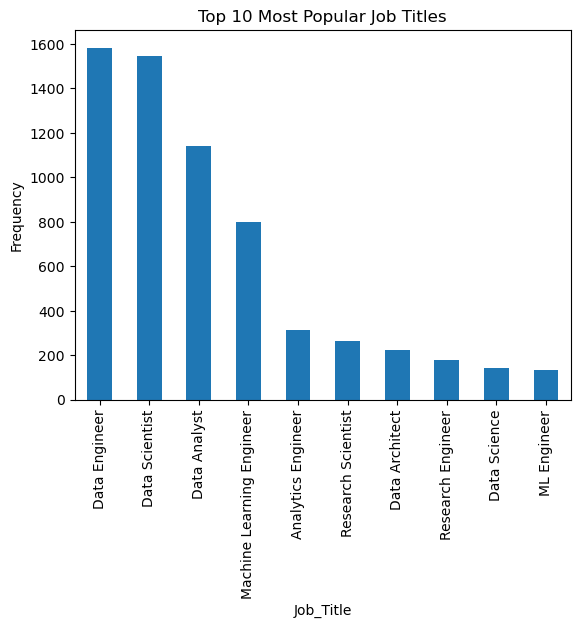

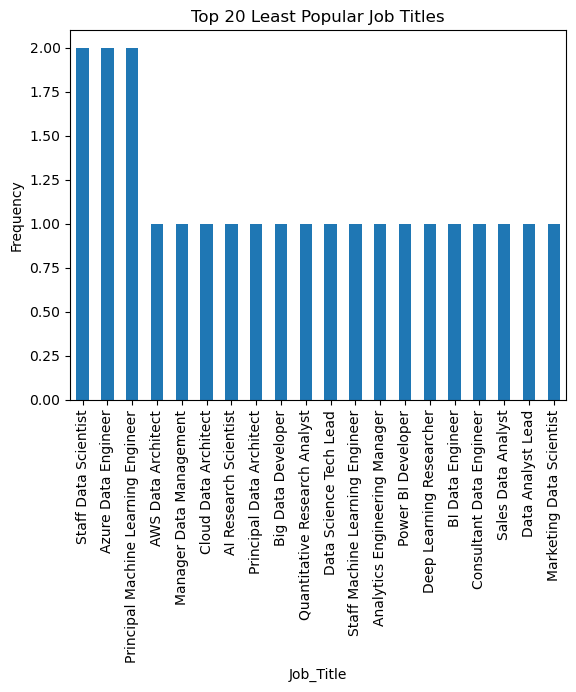

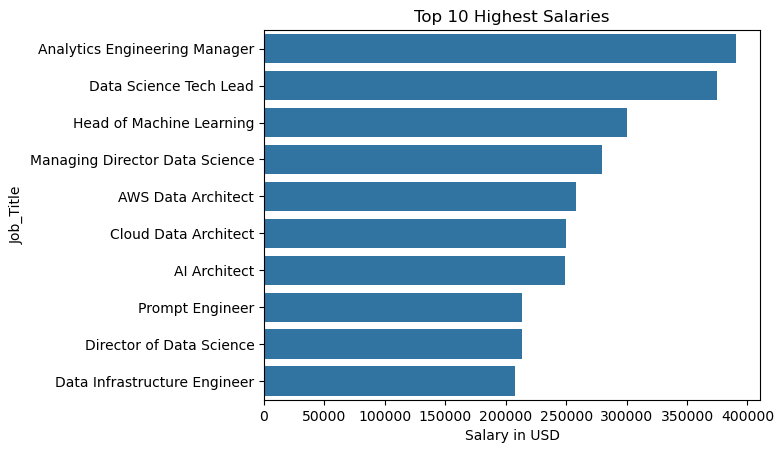

Job_Title
Analytics Engineering Manager      1
Data Science Tech Lead             1
Head of Machine Learning           7
Managing Director Data Science     2
AWS Data Architect                 1
Cloud Data Architect               1
AI Architect                      18
Prompt Engineer                   13
Director of Data Science          31
Data Infrastructure Engineer      16
Name: count, dtype: int64

In [159]:
top_titles = df_filtered['Job_Title'].value_counts().head(10)
top_titles.plot(kind='bar')
plt.title('Top 10 Most Popular Job Titles')
plt.ylabel('Frequency')
plt.show()

top_titles = df_filtered['Job_Title'].value_counts().tail(20)
top_titles.plot(kind='bar')
plt.title('Top 20 Least Popular Job Titles')
plt.ylabel('Frequency')
plt.show()

top_salaries = pd.DataFrame(df_filtered.groupby(['Job_Title'])['Salary_in_USD'].mean().nlargest(10))
top_salaries['Job_Title']=top_salaries.index
sns.barplot(x='Salary_in_USD', y='Job_Title', data=top_salaries)
plt.title('Top 10 Highest Salaries')
plt.xlabel('Salary in USD')
plt.show()

df_filtered['Job_Title'].value_counts()[top_salaries['Job_Title']]

In [161]:
job_salary_mean=pd.DataFrame(df_filtered.groupby(['Job_Title'])['Salary_in_USD'].mean())
job_salary_mean['Job_Title']=job_salary_mean.index
def salary_times_frequency(row):
    salary = row['Salary_in_USD']
    frequency = df_filtered['Job_Title'].value_counts()[row['Job_Title']]
    try:
        return salary * frequency
    except KeyError:
        print(f"Conversion rate for {currency} not found.")
        return None

job_salary_mean.apply(salary_times_frequency,axis=1).nlargest(10)

Job_Title
Data Scientist               2.319952e+08
Data Engineer                2.316654e+08
Machine Learning Engineer    1.428174e+08
Data Analyst                 1.240895e+08
Analytics Engineer           5.082692e+07
Research Scientist           5.046809e+07
Data Architect               3.677814e+07
Research Engineer            3.234211e+07
ML Engineer                  2.685784e+07
Data Science                 2.271944e+07
dtype: float64

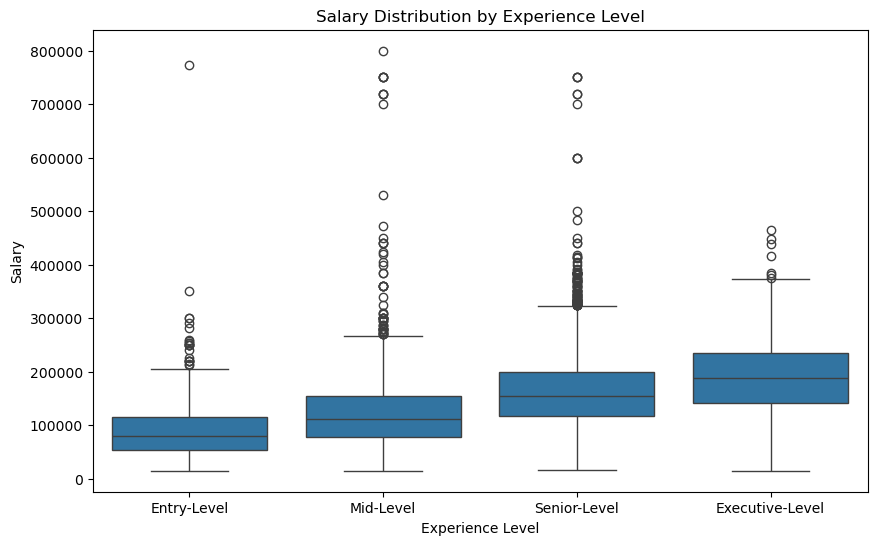

In [163]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Experience_Level', y='Salary_in_USD', data=df_filtered, order=['Entry-Level', 'Mid-Level', 'Senior-Level', 'Executive-Level'])
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary')
plt.show()

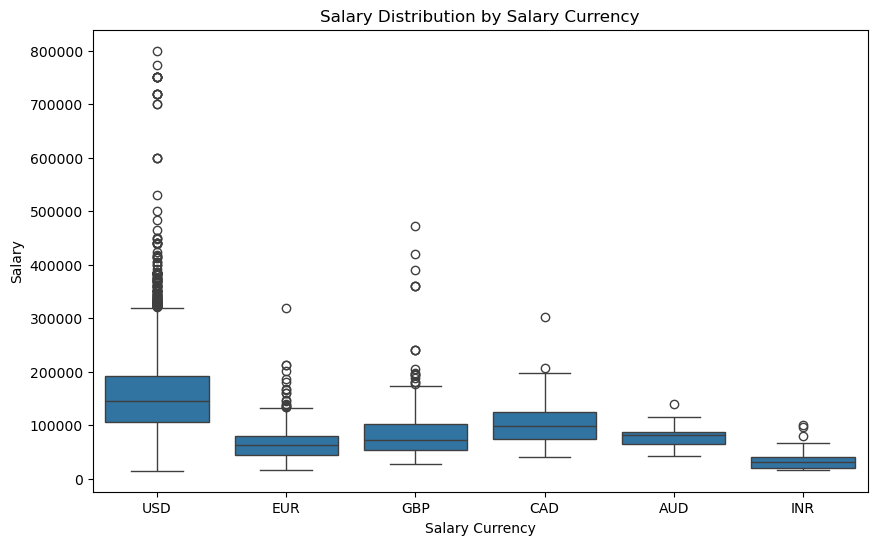

In [167]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Salary_Currency', y='Salary_in_USD', data=df_filtered, order=currencies)
plt.title('Salary Distribution by Salary Currency')
plt.xlabel('Salary Currency')
plt.ylabel('Salary')
plt.show()

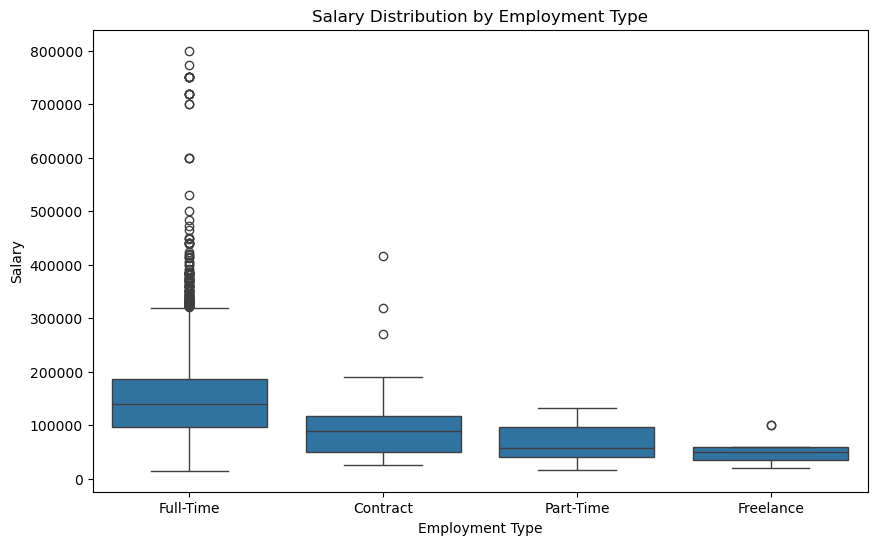

In [203]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Employment_Type', y='Salary_in_USD', data=df_filtered, order=df_filtered['Employment_Type'].unique())
plt.title('Salary Distribution by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Salary')
plt.show()

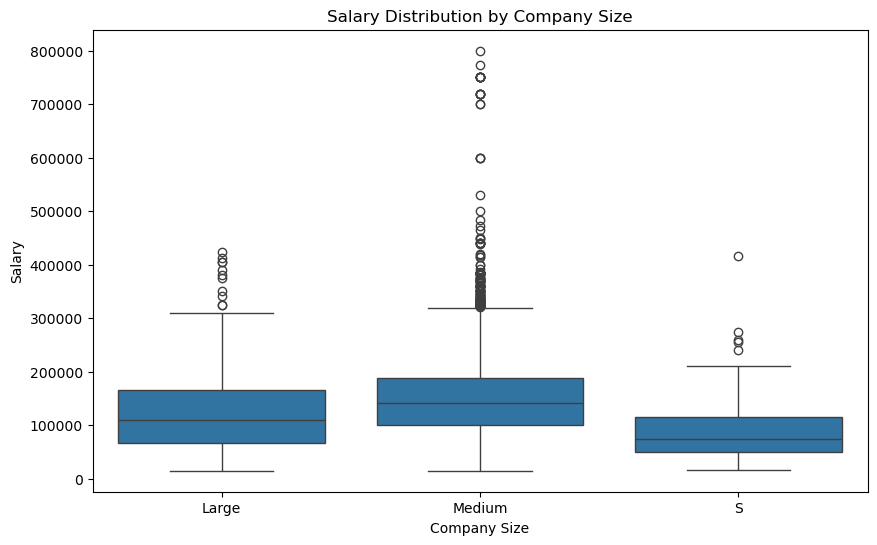

In [171]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Company_Size', y='Salary_in_USD', data=df_filtered, order=df_filtered['Company_Size'].unique())
plt.title('Salary Distribution by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Salary')
plt.show()

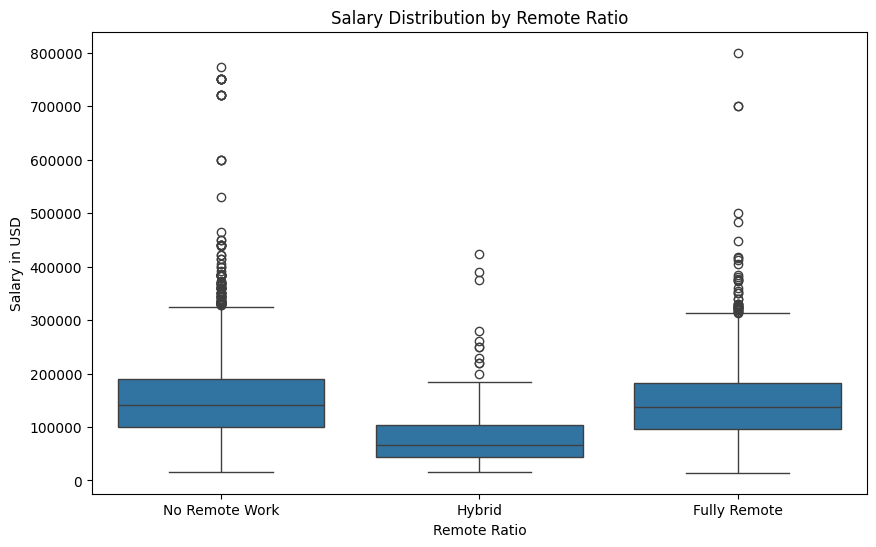

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Remote_Ratio', y='Salary_in_USD', data=df_filtered)
plt.title('Salary Distribution by Remote Ratio')
plt.xlabel('Remote Ratio')
plt.ylabel('Salary in USD')
plt.xticks(ticks=[0, 1, 2], labels=['No Remote Work', 'Hybrid', 'Fully Remote'])
plt.show()

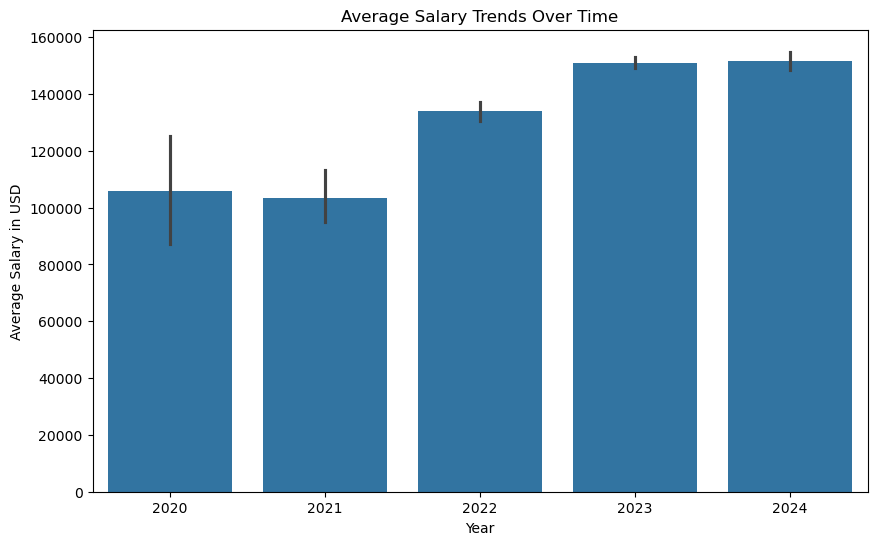

In [175]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Work_Year', y='Salary_in_USD', data=df_filtered, estimator='mean')
plt.title('Average Salary Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Salary in USD')
plt.show()

In [195]:
df_copy = df_filtered.copy(deep= True)
def label_to_numerical(df,col_names):
    for col_name in col_names:
        df[col_name] =df[col_name].map({label:i for i,label in enumerate(df[col_name].unique())})
    return df

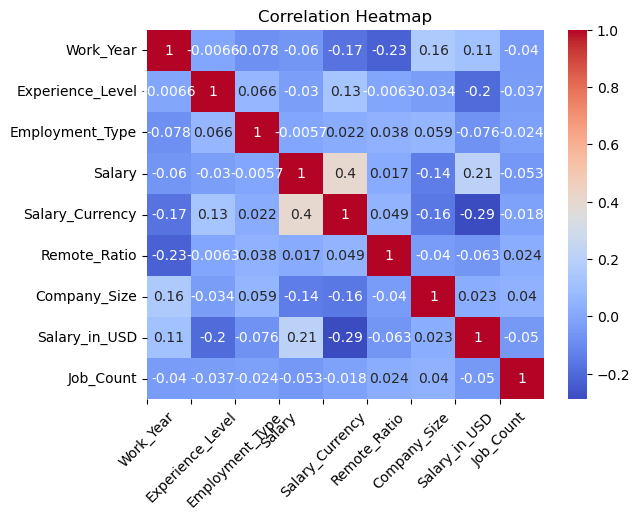

In [209]:
df_copy=label_to_numerical(df_copy,['Experience_Level','Employment_Type','Salary_Currency','Company_Size'])
def add_frequency_col(row):
    job_title=row['Job_Title']
    frequency = df_copy['Job_Title'].value_counts()[job_title]
    return frequency
df_copy['Job_Count']=df_copy.apply(add_frequency_col,axis=1)
numerical_cols = df_copy.select_dtypes(include=[np.number])
correlation = numerical_cols.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation= 45)
plt.title("Correlation Heatmap")
plt.show()

In [213]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [234]:
train_df=df_copy[['Work_Year','Experience_Level','Employment_Type','Salary_Currency','Remote_Ratio','Company_Size','Job_Count']]
test_df=df_copy['Salary_in_USD']
x_train,y_train,x_test,y_test=train_test_split(train_df,test_df)
model=DecisionTreeRegressor()
model.fit(x_train,y_train)
prediction=model.predict(x_test)
mean_squared_error(y_test,prediction)

AttributeError: 'DataFrame' object has no attribute 'to_array'